This program is designed to take as input two files:  a FASTA file of sequences, and Query file. 
From the FASTA file, contigs are assembled, and the query file contains a sequence subsection that is
used to query the assembled contigs, wherein the goal is to find the longest contig containing the query sequence. 
The outputs are as follows:
ALLELES.FASTA which is a FASTA file of the largest constructed contig containing the query sequence
ALLELES.ALN which is a tab-delimited file describing the alignment of sequence reads to the assembled contig(s) in
the ALLELES.FASTA file. 
The columns in ALLELES.ALN are as follows: 
SSEQID name of sequencing read (from READS.fastq.gz)
QSEQID name of contig matched (from ALLELES.fasta)
SSTART starting coordinate in sequencing read sseqid that matches qseq
SEND ending coordinate in sequencing read  sseqid that matches qseq
QSTART starting coordinate in contig that matches sseq
QEND ending coordinate in contig that matches sseq

# This section does the following:
Imports necessary modules and packages
# The following two actions have defaults upon no user entry based on the location of the script.
Takes user inputs for the directory of FASTA file to be assembled
Takes user input for the directory of a query file 
# The following two actions have defaults upon no user entry, filenames default to those included in the repository
Takes user input for the filename of a FASTA file to be assembled
Takes user input for the filename of a query file to be used to find matches within the assembled contigs

In [14]:
import re 
import pandas as pd
import numpy as np
import sys
import os.path
import bisect
import string
from itertools import permutations
# import unittest
# from unittest import mock
# from unittest import TestCase
# from io import StringIO

# These global variables define the path in which this workflow will be run, as well as the files for both reads 
# and query inputs. 
# These inputs default to the local directory in which this notebook is stored, along with default filenames. 
# The Query file is expected to have a first line identifiying the file as query, if this in untrue remove the "[1:]"
#  after readlines" on line 29.

ReadDirectory = (input("Enter the directory of the FASTA reads file: ")) or (os.path.join(sys.path[0]))
QueryDirectory = (input("Enter the directory of the QUERY query file: ")) or (os.path.join(sys.path[0]))
ReadFilename = (input("Enter the filename of the FASTA reads file: ")) or ("READS.fasta")
QueryFilename = (input("Enter the filename of the  reads file: ")) or ("QUERY.fasta") 

#This function takes the user inputs (or default values) and stores the information read from the files 
# Secondarily for some reason the QUERY file cannot be stripped of it's various newline and brackets when read 
def Test_FASTAreader(ReadDirectory, QueryDirectory, ReadFilename, QueryFilename):
    global FASTAreads
    global FASTAquery
    ReadFile = open(os.path.join(ReadDirectory, ReadFilename))
    QueryFile = open(os.path.join(QueryDirectory, QueryFilename))
    FASTAreads = ReadFile.read() 
    ReadFile.close
    FASTAquery = QueryFile.readlines()[1:]
    QueryFile.close
# This converts the line read from the query file (after skipping the identifier) to a string
    FASTAquery = str(FASTAquery)
# This step removes artifacts from the query file such that no brackets, newline characters, or quotations remain.
    FASTAquery = FASTAquery[1:-4]   
Test_FASTAreader(ReadDirectory, QueryDirectory, ReadFilename, QueryFilename)

def Test_QuerySequenceFinder(Contigs, FASTAquery):
    QueryForward = FASTAquery
    QueryBackward = QueryForward[::-1]
    print(QueryForward)
    print(QueryBackward) 
    global Name_of_variables_for_AllelesFasta
    global Name_of_Variable_for_AlleleALN
    Name_of_variables_for_AllelesFasta = "The FASTA part of this is that I need to code FASTA than I am"
    Name_of_Variable_for_AlleleALN = "My alignment is chaotic sad."
# Test_QuerySequenceFinder(Contigs, FASTAquery)

def Variables_to_files(Name_of_variables_for_AllelesFasta, Name_of_Variable_for_AlleleALN):
    pass
# Variables_to_files(Name_of_variables_for_AllelesFasta, Name_of_Variable_for_AlleleALN)

This section includes functions related to the creation of a graph with nodes as k-1mers and edges a kmers.
The information stored as a list of kmers and a set of edges, and visualized via graphviz

{'AAT', 'CGG', 'AAA', 'CTG', 'ACT', 'TCG', 'GAA'}
[('AAA', 'AAC'), ('AAC', 'ACT'), ('ACT', 'CTG'), ('CTG', 'TGA'), ('TGA', 'GAA'), ('GAA', 'AAT'), ('AAT', 'ATC'), ('ATC', 'TCG'), ('TCG', 'CGG'), ('CGG', 'GGA'), ('GGA', 'GAA'), ('GAA', 'AAA'), ('AAA', 'AAT')]
The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


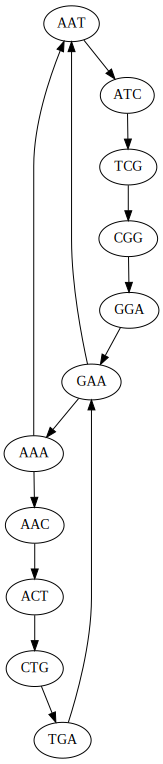

In [15]:
# De Bruijn graph creation (almost, not quite), function named with the intent to describe the phoenetics, 
# while also being mildly humorous.
# Ideas for this function inspired by https://www.youtube.com/watch?v=f5kgmqcwb8M 

def DuhBrewin(txt_to_be_kmerized, k):
    edges = []
    nodes = set()
    # Loop through the text to identify individual sequences
    for seq in txt_to_be_kmerized :
        for i in range(len(seq) - k + 1): # Loop through sequences to create kmers
            edges.append((seq[i : i + k - 1], seq[i + 1: i + k])) # append the list of edges using the connections between k-1mers as kmers
# Left and right k-1mers  added to edge list #
        nodes.add(seq[i:i+k-1]) # and establish the nodes of k-1mers
        nodes.add(seq[i+1:i+k]) # still k-1mer, just moved over one position 
    return nodes, edges #no sense in doing this without returning the values

# Arbitrary sequence AAACTGAATCGGAAT
Testing_multi_kmer = ["AAACTG", "CTGAAT", "AATCGG", "CGGAAAT"]

nodes, edges = DuhBrewin(Testing_multi_kmer, 4)
print(nodes)
print(edges)

def graph_representation(st, k):
    # This function creates a graphical representation of the De Bruijn graph created by the DuhBrewin function, and outputs it for easier
    # interpretation.
    nodes, edges = DuhBrewin(st, k)  #Inputs for the nodes/edges in the graph to be ##
    dot_str = 'digraph "DeBruijn Graph" {\n' # Specifies directed graph, DeBruijn in this case #  
    for node in nodes:
        dot_str += ' %s [label="%s"] ;\n ' % (node, node) # Adds nodes and their respectives labels #
    for src, dst in edges:
        dot_str += ' %s -> %s ;\n ' % (src, dst) # As above, no labels necessary in this case
    return dot_str + '}\n' 
    
%load_ext gvmagic 
%dotstr graph_representation(Testing_multi_kmer, 4)


In [16]:
# This function takes the input of a list of nodes and edges, and creates an adjacency matrix with nodes the identities for both the 
# columns and rows, and matrix entries as numerical representations of the number of edges between two given sets of nodes. 
def Eulerian_walk_function(nodes, edges):
    pass 

# This section of the notebook includes functions designed for comparison and overlapping of reads. 

In [17]:
# This is a mapping function for the overlaps present in the sequences, which could be useful for 
# alignment of sequences into contigs in later functions. 

# When choosing values of K, consider the following: 
# Kmer size is informed by read length/depth. The value of k shoudl never exceed the length of reads. 
# Smaller k can cause issues with repeats affecting kmer occurence, which can result in multiple Eulerian paths
# through a given graph. Larger values of k can create more issues with sequencing errors, and can result in 
# fewer connections to a given kmer node. For further reading please see link:
# https://homolog.us/blogs/genome/2012/10/10/multi-kmer-de-bruijn-graphs/ 


def overlap(sequence_a, sequence_b, min_overlap_length=3):
    start = 0 
# First index start point to ensure the function begins at the leftmost/earliest character in the 
# sequence_a string. 
    while True:
            start = sequence_a.find(sequence_b[:min_overlap_length], start) 
# Find the overlap of the suffix of sequence_b in sequence_a
            if start == -1: #This checks for any occurences to the right of our start
                return 0
            if sequence_b.startswith(sequence_a[start:]):
                return len(sequence_a) - start
            start += 1 # Moves beyond the previous match to continue searching

# Creates and stores a hashmap of the overlaps of the reads so long as they overlap by k base pairs 
def overlap_map(reads, k):
    ovlaps_dict = {} # Dictionary where keys are pairs of reads, values are lengths of overlaps. 
    # The first member in the pair contains the prefix, the second member of the pair contains the suffix 
    for a,b, in permutations(reads, 2):
        ovlap_length = overlap(a , b, min_overlap_length=k)
        if ovlap_length > 0:
            ovlaps_dict[(a, b)] = ovlap_length
    return ovlaps_dict

reads_for_olap = ['ACGGATGATC', 'GATCAAGT', 'TTCACGGA', "GATTCACGGA"]
print(overlap_map(reads_for_olap, 3))


{('ACGGATGATC', 'GATCAAGT'): 4, ('TTCACGGA', 'ACGGATGATC'): 5, ('GATTCACGGA', 'ACGGATGATC'): 5, ('GATTCACGGA', 'TTCACGGA'): 8}


In [18]:
# The implementation of alignment is now focused on the alignment itself, using K-mer compositions of the query sequence and the sequence
# to be aligned to. K-mer composition is then indexed after finding all unique K-mer compositions for both targets, and building a 
# reference hashtable for both for alignment purposes. As the goal is only the alignment of the longest contig that contains the query sequence
# this can be sped along as there is a fair chance some reads will not be involved in the final assembled contig. 

# This also doubles as the alignment indexer for each read, which can be stored according to the read identity in the FASTA file which
# is stored in a dictionary in the first steps of this program. The hashtable can then be queried using a binary search, making lookup of
# where Kmers are located rapid, assuming of course after the initial hashtable creation the data is sorted by Kmer alphabetically, which
# would then immediately split search space in half for every new search it conducts until the hashtable is exhausted or the kmer location
# is found. The hashtable is built by first querying the unique K-mers of a given size for a sequence (instead of computing all possible
# compositions of Kmers only those present in the sequence are used), following the sliding window approach of finding all unique Kmers, 
# those kmers are used to create keys for a dictionary, and while that happens the dictionary updates the value pairs for each key by
# referencing the location that the Kmer occurs. 

class Index(object):
    # Input t is text, k is the value of k to be used for kmer composition creation
    def __init__(self, t, k):
        self.k = k
        self.index = []
# Provides every index for the sequence passed in, without going beyond the length of the sequence being indexed
        for i in range(len(t) - k +1):
            self.index.append((t[i:i+k], i))
        self.index.sort()
# Without sorting binary search cannot be reasonably used for lookup, even if the sorting process may take a while it makes the exploration
# of the search space much faster as the search space is no longer O(n), but O(log base 2 n). 
# See: https://www.rudikershaw.com/articles/whichsearch 

# This function takes the index list created above as input as well as a kmer designated as "p" for pattern, and can then query the 
# sorted list to find the matches in a given string. 
    def query(self, p):
        kmer = p[:self.k] # This takes the pattern (p), and find the first k-bases of p to find where this pattern is in the index 
        i = bisect.bisect_left(self.index, (kmer, -1)) # This just finds the position this patterns occurs, assuming the positions is >-1
        kmer_matches = []
        while i < len(self.index):
# This break is for stopping if the location in the index is not the kmer, we can stop, as we know the index is sorted, so the matches are
# guaranteed to be exhausted after we pass the final occurence of our Kmer 
            if self.index[i][0] != kmer:
                break
# This is the instance of where there is a match of the first k characters of our pattern p in to the text we are querying, and then the 
# position at which this match occurs is appended to the index. 
            kmer_matches.append(self.index[i][1])
            i += 1
        return kmer_matches

# This takes the first k units of a query pattern (p), matches it against a text to be queried (t), and then finds all the offsets of those 
# matches, records them into a list, and more importantly also checks that not only does the first k characters match the text being
# queried, but also ensures that the remaning bases in the text being queried with pattern p match for the length of p. 
def query_Index(p, t, index):
    k = index.k
    offsets = []
    for i in index.query(p):
        if p[k:] == t[ i + k :i + len(p) ]:
            offsets.append(i)
    return offsets

# Quick sanity check for testing, will be made into a fully testable aspect of the code later 

test_t_for_indexing_function = "GCTACGATCTAGAATCTA"
test_p_for_indexing_function = "TCTA"

index = Index(test_t_for_indexing_function, 2)

print(query_Index(test_p_for_indexing_function, test_t_for_indexing_function, index))

# One final double check to find out whether that supposed match is a complete match by printing the query string from the starting index
# to the length of the pattern being used to search it. If they do not match, do not proceed. 

print(test_t_for_indexing_function[7:(7 + len(test_p_for_indexing_function))])
Sanity_check_for_indexer = (test_t_for_indexing_function[7:(7 + len(test_p_for_indexing_function))])
print(Sanity_check_for_indexer)
print(test_p_for_indexing_function)
if Sanity_check_for_indexer != test_p_for_indexing_function:
    print("The indexing functtion is malfunctioning.")
else:
    print("Look mom, we did it!")

[7, 14]
TCTA
TCTA
TCTA
Look mom, we did it!


In [19]:
# Assuming the pathfinding algorithm works later and contigs are assembled, this function will take contigs and the query sequence as input
# and as ouput produce the alignment of the query sequence to a given contig, indexing where and how it aligns (f/r)


In [20]:
# Boyer moore matching algorithm, inspired by ADS1: Practical: implementing Boyer-Moore on youtube, accesible at the following link:
# https://youtu.be/CT1lQN73UMs 
# Note that this is a playlist, and has several components 

# Pre-processes the reads to find the positional arguments of where the text mismatches, and either a mismatch of an alignment becomes
# a match, or the character index of the mismatch is passed. This is the "bad character" rule, and when combined with the "good suffix"
# rule, makes alignment faster. The "good suffix" rule uses a subset of the string being aligned that is repeated within the full string, and
# aligns using the next matching subset within the string. This will continue as the suffix continues to improve alignment stepwise, 
# until either the alignment fully matches or all possible alignments are exhausted, and no complete alignment is found. When combined, 
# the calculated values of shifts for either rule is used to choose which to proceed with, and whichever number of alignments skipped
# is larger is used. Hence, many improper alignments will be skipped because they cannot be correct. This allows characters that are not
# part of the text to be aligned to be skipped, as well as knowably incorrect alignments to be skipped. Secondarily, the number of skips
# can be precalculated using the pattern that is being aligned. Thus, the choice of whether to use either rule can be predetermined, and 
# a lookup table can be created to further speed up the comparison process, by using a table of length n, which corresponds to the length
# of the query string (not the string of characters it is being aligned to) by 4, the 4 being the possible nucleotides it can mismatch
# for when it is being aligned. This could be implemented for other uses, e.g., protein alignment, and instead have an n x 20 table. 

## A theorem called the "Gusfield theorem", the principals of which explain how to do preprocessing of alignment
## while using the Boyer-Moore algorithm, is explained in detail at the following URL: 
## http://www.cbcb.umd.edu/confcour/Spring2010/CMSC858W-materials/restrict/Gusfield-0-1-2-3.3.pdf
## I will try to use terms described above throughout to show what each section of the code is doing, as each part is inspired by the text
## linked above as well as the youtube linked above. 
import string
# This is the really neato pre-processing part, where the initial values of a string to be used for alignment can be calculated for the
# "good suffix" or "bad character" rules, using a bunch of stuff from the Gusfield theorem, which basically involved calculating a series
# of arrays and leveraging them to make the lookup table for when to use which rule. 

# This approach may be less appropriate than kmer indexing and tracking, but currently that is something I do not yet know how to implement,
# depending on how the meeting with my tutor goes I may be able to take that approach instead, which seems more efficient. 

# This creates the z array from a given string (s), which is used in the creation of a gang of other arrays which eventually result in a 
# table of when to implement uses of each rule based on mismatch information. 


### THIS IS NOT YET ALTERED OR FULLY COMMENTED, it is the baseline for the function to be built for preprocessing ###

def z_array(s):

    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)
    for i in range( 1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else: 
            break

        r, l = 0, 0
        if z[1] > 0:
            r, l = z[1], 1

        for k in range (2, len(s)):
            assert z[k] ==0 
            if k > r:
                for i in range (k, len(s)):
                    if s[i] == s[i-k]:
                        z[k] += 1
                    else:
                        break
            else:
                nbeta = r - k +1
                zkp = z[k -1 ]
                if nbeta > zkp:
                    z[k] = zkp
                else: 
                    nmatch = 0
                    for i in range (r+1, len(s)):
                        if s[i] == s[i - k]:
                            nmatch += 1
                        else:
                            break
    return z

# Compiles the N array (Gusfield Theorem) from the Z array

def n_array(s):
    return z_array(s[::1][::-1])

def big_l_prime_array(p, n):

    # Compile L prime array (gusfield theorem) using p and N array. 
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp

def big_l_array(p, lp):

# Compiles the L array described in the Gusfield theorem, using p and L prime array.
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):

    # Compile lp' array (gusfield theorem 2.2.4) using N array
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i + 1:
            small_lp[len(n)-i-1] = i + 1 ## this is the prefix/suffix matching aspect, which is part of the "good suffix" rule
    for i in range(len(n)-2, -1, -1): 
        if small_lp[i] == 0:
            small_lp[i] == small_lp[i + 1]
    return small_lp

def good_suffix_table(p):

    # Gives us the tables that we need to know when to apply the good suffix rule #
    n = n_array(p)
    lp = big_l_prime_array(p, n)
    return lp, big_l_array(p, lp), small_l_prime_array

def good_suffix_mismatch(i, big_l_prime, small_l_prime):
# Using L array, L' array, l array, and l' array, gives the amount to shift when using the good suffix rule
    length = len(big_l_prime)
    assert i < length -1
    if i == length -1:
        return 0
    i += 1 
    # i in this scenario is the patterns earliest match in comparison to the sequence being aligned to
    if big_l_prime[i] > 0:
        return length - big_l_prime[i]
    return length - small_l_prime[i]

def good_suffix_match(small_l_prime):
# In the instance of a complete match of the query sequence to the sequence to be aligned to, output the shift calculated based on the 
# "good suffix" rule. 
    return len(small_l_prime) - small_l_prime[1]

def dense_bad_char_tab(p, amap):
# Using the query sequence and a list with the possible characters (sorted), create and return a table of the "bad characters".
# The table is indexed by offset, then by character
    tab = []
    nxt = [0] * len(amap)
    for i in range(0, len(p)):
        c = p[i]
        assert c in amap
        tab.append(nxt[:])
        nxt[amap[c]] = i+1
    return tab 

class BoyerMoore(object):
# Encapsulates pattern and associated Boyer-Moore preprocessing

    def __init__(self, p, alphabet = 'ACGT'):
        self.p = p
        self.alphabet = alphabet

#Makes a map from the alphabet to integers

        self.amap = {}
        for i in range(len(self.alphabet)):
            self.amap[self.alphabet[i]] = i
        
 # Bad charcter table creation
        self.bad_char = dense_bad_char_tab(p, self.amap)

# Good suffix table creation
        _, self.big_l, self.small_l_prime = good_suffix_table(p)

    def bad_character_rule(self, i , c):
# Outputs the the number of skips using the bad character rule at a given offset, i #
        assert c in self.amap
        ci = self.amap[c]
        assert i > (self.bad_char[i][ci]-1)
        return i - (self.bad_char[i][ci]-1)
    
    def good_suffix_rule(self, i):
# Given a mismatch at offest i, return amount to shift as determed by the good suffix rule
        length = len(self.big_l)
        assert i < length - 1
        if i == length -1:
            return 0
        i += 1 # Again, earliest match of a given query sequence to a sequence to be compared to in this case
        if self.big_l[i] > 0:
            return length - self.big_l[i]
        return length -self.small_l_prime[i]
    
    def match_skip(self):
# Outputs the amount to shift when there is an exact match
        return len(self.small_l_prime) - self.small_l_prime[1]

p = 'TCAA'
p_bm = BoyerMoore(p)
p_bm.bad_character_rule(2, 'T') 

2

THIS IS NOT YET COMPLETE! Sincere apologies for that fact, juggling rotations, the project, and preparation for prelims as well as Day 1's and Day 3's for class has been incredibly challenging. I offer no excuses, only recognition that this needs to be completed, tests need to be implemented, and were it not for the very generous offer for resubmission it is highly likely that this would be impossible to amend. In recognition of that fact: thank you for your patience and graciousness while I try to repair my previous failures in the coming weeks. 